In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Step 1: Load and preprocess the image
def preprocess_image(image_path):
    # Read in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Image at path {image_path} not found.")

    # Create mask for near-white pixels in grayscale
    mask = cv2.inRange(image, 240, 255)

    # Set those pixels to black
    image[mask > 0] = 0

    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

    return image, blurred_image

# Step 2: Enhance the brightness using CLAHE
def enhance_brightness(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(image)
    return enhanced_image

# Step 3: Filter the Top 10% Brightest Areas
def filter_brightest_areas(image, percentile=98.5):
    threshold_value = np.percentile(image, percentile)
    _, brightest_areas = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
    return brightest_areas

# Step 4: Detect Edges Using Canny Edge Detection
def detect_edges(image, sigma=0.33):
    v = np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edges = cv2.Canny(image, lower, upper)
    return edges

# Step 5: Extract the Brightest Line Using Contours
def extract_brightest_line(image, edges):
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    best_contour, best_score = None, -1
    for contour in contours:
        mask = np.zeros_like(image, dtype=np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, -1)
        brightness = cv2.mean(image, mask=mask)[0]
        length = cv2.arcLength(contour, False)
        score = brightness * length   # joint metric
        if score > best_score:
            best_score = score
            best_contour = contour
    return best_contour
# Step 6: Interpolate the Contour Points
def interpolate_contour(contour, image_shape):
    if contour is None:
        return np.zeros(image_shape, dtype=np.uint8)
    
    # Extract x and y coordinates from the contour
    x = contour[:, 0, 0]
    y = contour[:, 0, 1]
    
    # Sort the points based on x values
    sorted_indices = np.argsort(x)
    x = x[sorted_indices]
    y = y[sorted_indices]
    
    # Remove duplicate x values
    x, unique_indices = np.unique(x, return_index=True)
    y = y[unique_indices]
    
    # Interpolate using cubic spline
    cs = CubicSpline(x, y)
    x_new = np.linspace(x.min(), x.max(), num=image_shape[1])
    y_new = cs(x_new).astype(int)
    
    # Create an image with the interpolated line
    interpolated_image = np.zeros(image_shape, dtype=np.uint8)
    for i in range(len(x_new) - 1):
        cv2.line(interpolated_image, (int(x_new[i]), y_new[i]), (int(x_new[i+1]), y_new[i+1]), 255, 2)
    
    return interpolated_image

def overlay_line_on_image(original, line_img):
    overlay = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    ys, xs = np.where(line_img > 0)
    overlay[ys, xs] = (0, 0, 255)  # red line
    return overlay

# Main function
def main(image_path):
    try:
        orig, pre = preprocess_image(image_path)
        enh = enhance_brightness(pre)
        brightest = filter_brightest_areas(enh, percentile=98.5)
        edges = detect_edges(brightest, sigma=0.33)
        contour = extract_brightest_line(enh, edges)
        line_img = interpolate_contour(contour, pre.shape)
        overlay = overlay_line_on_image(orig, line_img)

        # Plot
        fig, axs = plt.subplots(2, 3, figsize=(15, 10))
        axs[0,0].imshow(orig, cmap="gray"); axs[0,0].set_title("Original")
        axs[0,1].imshow(pre, cmap="gray"); axs[0,1].set_title("Preprocessed")
        axs[0,2].imshow(enh, cmap="gray"); axs[0,2].set_title("Enhanced")
        axs[1,0].imshow(brightest, cmap="gray"); axs[1,0].set_title("Brightest areas")
        axs[1,1].imshow(edges, cmap="gray"); axs[1,1].set_title("Edges")
        axs[1,2].imshow(overlay); axs[1,2].set_title("Brightest line overlay")
        plt.show()
    except Exception as e:
        print(f"An error occurred: {e}")



In [ ]:
import os
folder = '/Users/ammaster10/Documents/Github/Year4/CNVresearch/Validation/340_Folder/340_Test/'

image_files = [f for f in os.listdir(folder) if f.lower().endswith('.jpeg') or f.lower().endswith('.jpg')]

image_files.sort()

for image_file in image_files:
    image_path = os.path.join(folder, image_file)
    print(f"Processing: {image_file}")
    main(image_path)


In [3]:
import cv2
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

def extract_rpe_line(image_path):
    oct_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if oct_img is None:
        raise FileNotFoundError(f"Could not load image: {image_path}")
    # Create mask for near-white pixels in grayscale
    mask = cv2.inRange(oct_img, 240, 255)
    # Set those pixels to black
    oct_img[mask > 0] = 0

    # Step 1: Denoise and convert to float for better intensity scaling later
    # Using Gaussian blur for a different denoising effect, you might experiment
    # with different denoisers like bilateralFilter or fastNlMeansDenoising
    denoised = cv2.GaussianBlur(oct_img, (5, 5), 0).astype(np.float32)

    rows, cols = denoised.shape
    G = nx.DiGraph()

    # Step 2: Define "costs" for traversing the image.
    # We want to find a path through "dark" regions of the inverted image,
    # which correspond to "bright" regions in the original image (edges).
    # A common approach for edge detection with shortest path is to use
    # the gradient magnitude or simply the inverted intensity.
    # Here, we're using 255 - intensity, so lower values are preferred.

    # Add nodes to the graph
    for y in range(rows):
        for x in range(cols):
            G.add_node((x, y))

    # Add edges to the graph. We only need to consider edges moving forward (x+1).
    # This greatly reduces the number of edges and potential cycles for a "line" extraction.
    # We consider 3 possible movements for each pixel: right, right-up, right-down.
    # The weight of the edge should reflect the cost of *entering* the destination pixel.
    for y in range(rows):
        for x in range(cols - 1): # Iterate up to cols-2 because we look at x+1
            current_cost = 255 - denoised[y, x] # Cost of the current pixel

            # Edge to (x+1, y)
            cost_right = 255 - denoised[y, x+1]
            G.add_edge((x, y), (x+1, y), weight=cost_right)

            # Edge to (x+1, y+1) if within bounds
            if y + 1 < rows:
                cost_diag_down = 255 - denoised[y+1, x+1]
                G.add_edge((x, y), (x+1, y+1), weight=cost_diag_down)

            # Edge to (x+1, y-1) if within bounds
            if y - 1 >= 0:
                cost_diag_up = 255 - denoised[y-1, x+1]
                G.add_edge((x, y), (x+1, y-1), weight=cost_diag_up)

    # Define start and end nodes more precisely.
    # Start nodes are all pixels in the first column.
    # End nodes are all pixels in the last column.
    start_nodes = [(0, y) for y in range(rows)]
    end_nodes   = [(cols - 1, y) for y in range(rows)]

    best_path = None
    best_cost = np.inf

    # Perform Dijkstra's from a virtual source node to all possible end nodes.
    # This is more efficient than running Dijkstra for every possible start-end pair.
    # Create a virtual source node and connect it to all start_nodes with zero weight.
    # Then run Dijkstra from this virtual source to all end_nodes.
    virtual_source = 'source'
    for s_node in start_nodes:
        G.add_edge(virtual_source, s_node, weight=0)

    # Compute shortest paths from the virtual source to all other nodes
    try:
        # Using Dijkstra's from a single source to all reachable nodes.
        # This will give us the shortest path from 'source' to every node in the graph.
        length = nx.shortest_path_length(G, source=virtual_source, weight='weight')
        paths = nx.shortest_path(G, source=virtual_source, weight='weight')

        for e_node in end_nodes:
            if e_node in length: # Check if the end node is reachable
                current_cost = length[e_node]
                if current_cost < best_cost:
                    best_cost = current_cost
                    best_path = paths[e_node]
        
        # Remove the virtual source from the path if found
        if best_path and best_path[0] == virtual_source:
            best_path = best_path[1:]

    except nx.NetworkXNoPath:
        print("No path found between virtual source and any end node.")
        return None, None, denoised.astype(np.uint8)

    if best_path:
        xs, ys = zip(*best_path)
        return list(xs), list(ys), denoised.astype(np.uint8)
    return None, None, denoised.astype(np.uint8)


Processing: CNV-1016042-108.jpeg


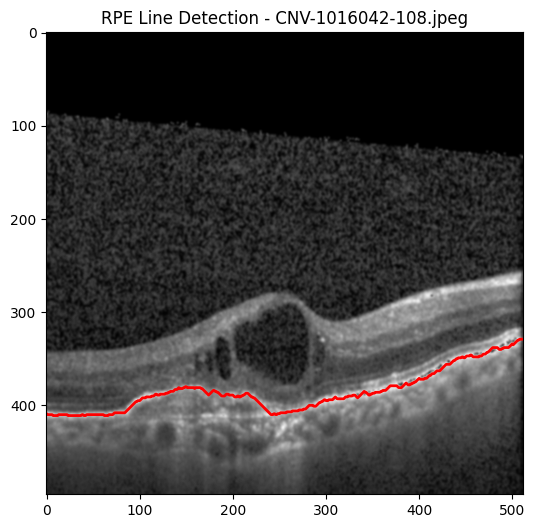

Processing: CNV-1016042-12.jpeg


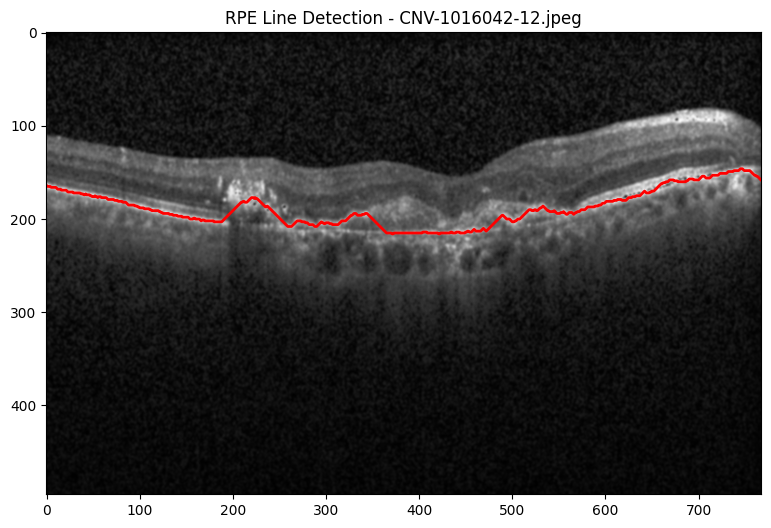

Processing: CNV-1016042-191.jpeg


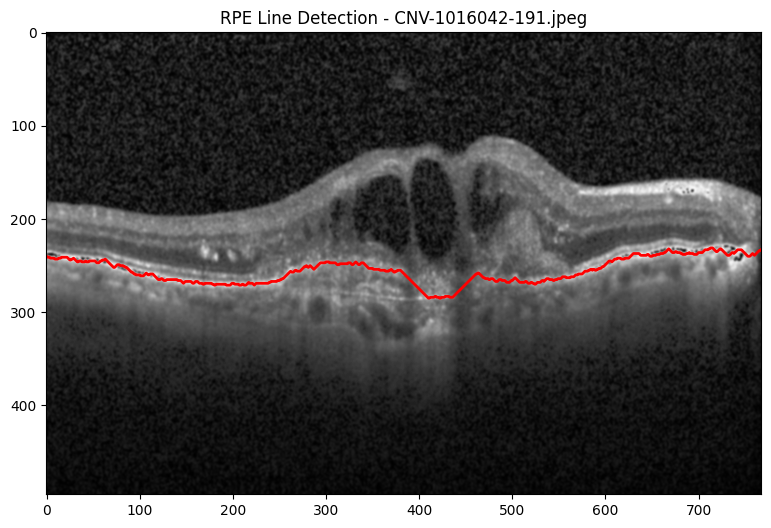

Processing: CNV-1016042-42.jpeg


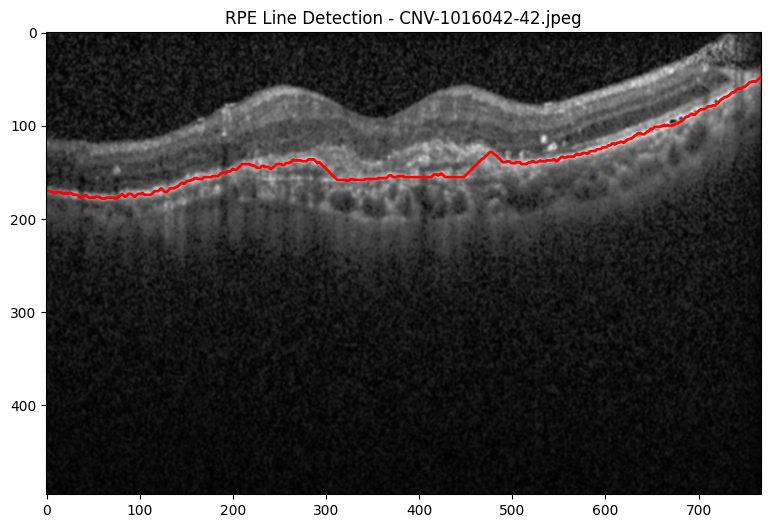

Processing: CNV-103044-58.jpeg


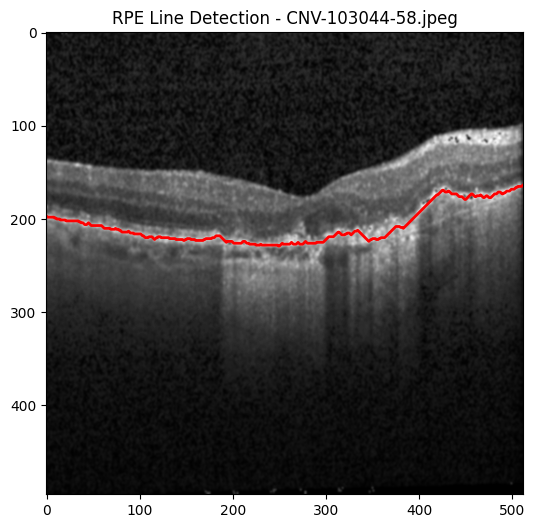

Processing: CNV-103044-62.jpeg


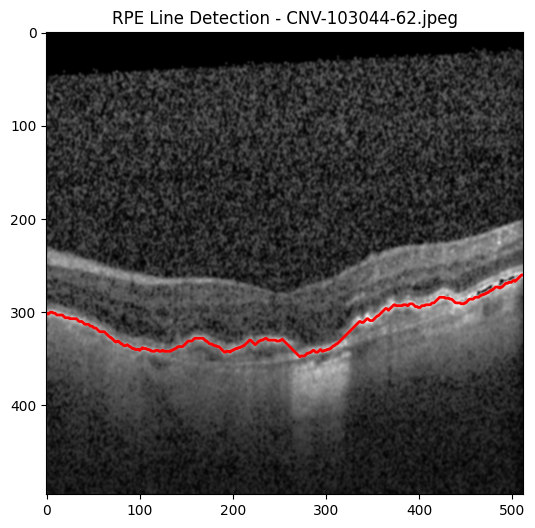

Processing: CNV-1083927-51.jpeg


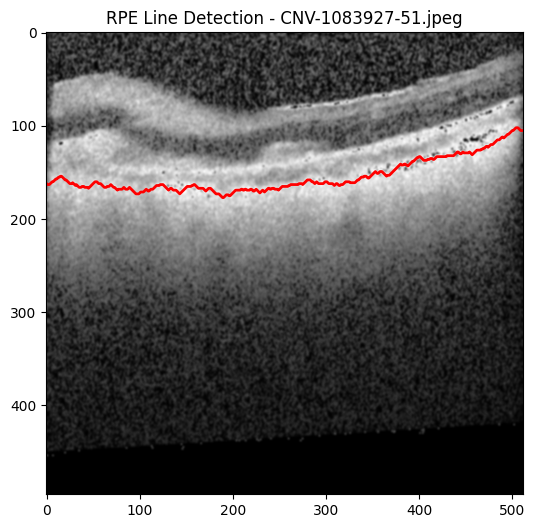

Processing: CNV-1083927-97.jpeg


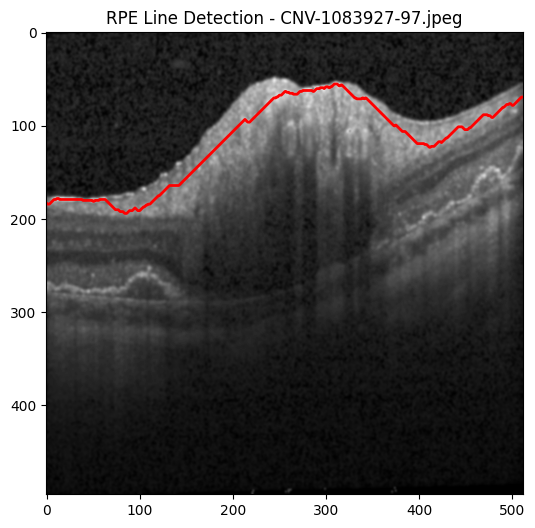

Processing: CNV-1112835-153.jpeg


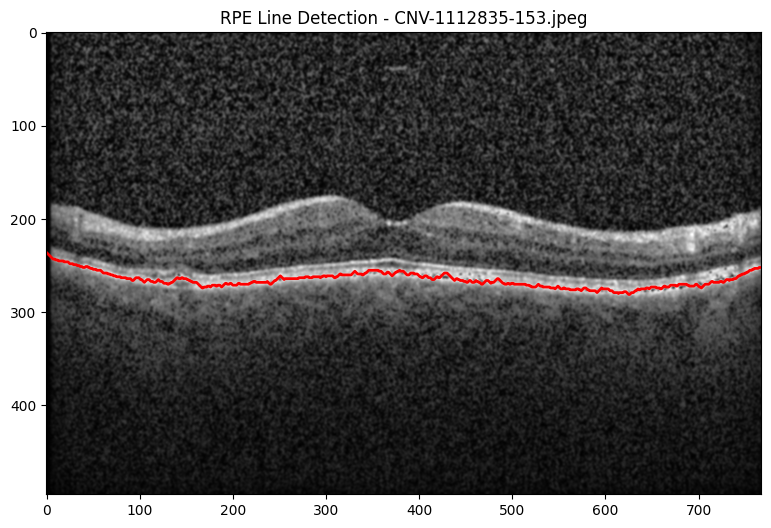

Processing: CNV-1112835-372.jpeg


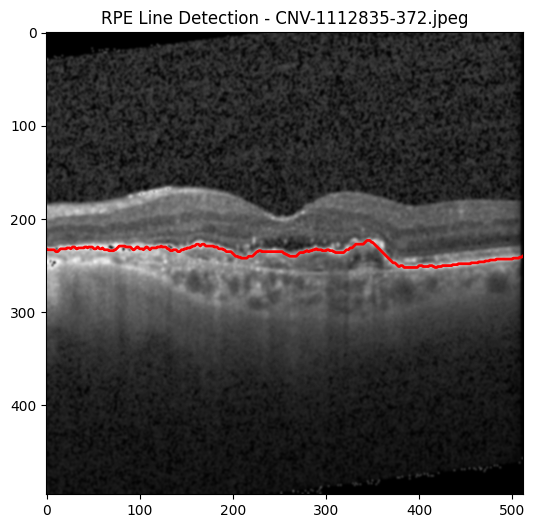

In [4]:
import os
import matplotlib.pyplot as plt

folder = '/Users/ammaster10/Documents/Github/Year4/CNVresearch/Validation/340_Folder/340_Test/'

image_files = [f for f in os.listdir(folder) if f.lower().endswith('.jpeg') or f.lower().endswith('.jpg')]

image_files.sort()
maxcount = 10
for image_file in image_files[:maxcount]:
    image_path = os.path.join(folder, image_file)
    print(f"Processing: {image_file}")
    
    xs, ys, denoised = extract_rpe_line(image_path)
    
    if xs is not None and ys is not None:
        # Display the results
        plt.figure(figsize=(12, 6))
        plt.imshow(denoised, cmap='gray')
        plt.plot(xs, ys, 'r-', linewidth=2)
        plt.title(f"RPE Line Detection - {image_file}")
        plt.show()
    else:
        print(f"No valid path found for {image_file}")
